# Sentiment Analysis

Data has been sourced from Kaggle.
https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge

From Kaggle: You are provided with a large number of Wikipedia comments which have been labeled by human raters for toxic behavior. The types of toxicity are:

toxic
severe_toxic
obscene
threat
insult
identity_hate

Goal is to use word embeddings and a Recurent Neural Network to predict if a comment is toxic vs non-toxic comments.

In [2]:
#imports
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Activation, Embedding, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
import tensorflow as tf

from statistics import mean
from itertools import groupby
from contractions import contractions_dict
from autocorrect import Speller
import time
import os
import re
import nltk
import random
import numpy as np
import seaborn as sns
import matplotlib as plt
import matplotlib.pyplot
import pandas as pd
import csv

## Read training data

Data set was obtained from kaggle Toxic Comment Classification Challenge.

https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge

For the purposes of this study we will only be using the comment_text and the toxic flag.  Since the the other categories are not exclusive they can be hard to categorize, and as such will be removed.

See an exmaple of some of the data below.

### Warning this is currently unfiltered internet data, as such expect to see some words, comments phrases that are potentially offensive.

In [3]:
# setting to display full text in output
pd.set_option('display.max_colwidth', None)
random.seed(30)


#read the dataset
train_raw_df = pd.read_csv("train.csv",encoding = "ISO-8859-1")
#sample 5 random rows
train_raw_df.sample(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
7880,14f8b9fd4928799e,"I am not employed by the town, nor have I ever been. Even if they sections I added are inappropriate for the article, please explain how they were added by members the town government when I was the one who did so.\n\nThe media and education sections were based off of the Charlottesville, Virginia article. I am going to add the education section back since you said it was okay, as well as adding the mayor and town manager back to the info box.\n\nThanks for the criticisms.",0,0,0,0,0,0
63307,a966a5a5c70b0531,"Well that is not the case, almost every writer/ comedian is known as English/Welsh or Scottish, except Ricky and Stephen Merchant. Ricky should be stated as a English comedian, in the introduction. In the infobox under nationality it should be British.",0,0,0,0,0,0
81381,d9aeef95410e6267,Colonial Revival garden \n\nThanks for fixing it up! The article had been on my watchlist because it had some wikifying concerns and titling issues. It's a much better article now! (t â¢ c),0,0,0,0,0,0
65257,ae9b09ec9bf020f5,"Talk about inane support for bad moderators. No wonder no collegiate or self respecting person takes Wikipedia seriously, it's worse than an internet forum around here. Whatever dudes, continue to play your game with someone else's lives. I hope your constant reassurance to the Japanese that there was wide-spread anti-semantic behavior directed at them during their 2011 tsunami gets you targeted by a hate group. Seriously guys, burn in hell for being miserable moderators that only aim to spread lies to somehow record popular opinion of a time that was actually not even on anyone's mind during the incident.",1,0,0,0,0,0
16305,2afd0b8c142132e1,CrankScorpion\n\nYou imaged these basaltic columns near Lamont-Doherty Earth Observatory in Palisades New York. I was unaware of these columns and I would like to vist them and image them.\nWhat road are these columns on? I wish to visit. I live in The Bronx. Can you send me directions to these columns?\n\nThanks\n\n24.44.189.124,0,0,0,0,0,0


You will notice the comments have missspellings, typos, weird characters, bad use of capitals, numbers, urls and all the other things that might show up in free text on the internet.

### Data Basics
In an effort to keep this problem managable from a memory perspective, we are going to filter some of the longer comments out of the code, this will help the model later with memory, but also makes the problem a little easier on home computers.  This is obviously a practical decision rather than a statistical one.

Number of comments: 159571
Mean of comment length: 67.30
Std Deviation of comment length: 99.25
Number of comments filtered: 0

toxic
0    144277
1     15294
Name: id, dtype: int64


<AxesSubplot:ylabel='id'>

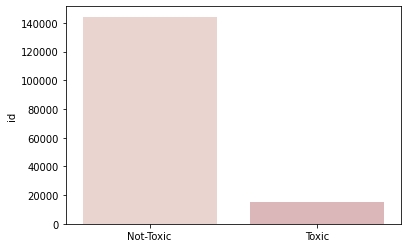

In [4]:
train_raw_data_len = len(train_raw_df)
print(f"Number of comments: {train_raw_data_len}")
print(f"Mean of comment length: {train_raw_df.comment_text.str.split().str.len().mean():.2f}")
print(f"Std Deviation of comment length: {train_raw_df.comment_text.str.split().str.len().std():.2f}")

# remove any comments longer than 3 std deviations above the mean
# cuttoff = train_raw_df.comment_text.str.split().str.len().std()*2.2 + train_raw_df.comment_text.str.split().str.len().mean()
# train_raw_df = train_raw_df[train_raw_df.comment_text.str.split().str.len().lt(cuttoff)]

print(f"Number of comments filtered: {train_raw_data_len - len(train_raw_df)}\n")

print(train_raw_df.groupby("toxic").id.count())

%matplotlib inline
sns.barplot(["Not-Toxic","Toxic"],train_raw_df.groupby("toxic").id.count(), palette=sns.cubehelix_palette(8))

## Drop Unused Colmns

In [5]:
clean_df = train_raw_df.drop(['id', 'severe_toxic','obscene','threat','insult','identity_hate'], axis=1)
clean_df.reset_index(drop=True,inplace=True)

In [6]:
# This won't be used again, and we don't want excess memory being used needlessly.
del train_raw_df

## Cleaning and Preprocessing

Here we are going to attempt to clean up some of the data, removing bad characters, potential misspellings, links etc.  Since we are using GLoVe for this it is possible to also learn from emojis, characters, stopwords and symbols so we need to be careful about overcleaning because in the processes we are potentially loosing information.  For example :) might be an indication of a joke, so removing the symbol potentially context.  Since GLoVe learns its embeddings its possible to associate the "word" :) with a vector space, hense we don't want to remove it.

That said, for purposes of this project, we will split contractions, remove links, turn things to lower, and remove newlines at a minimum.

In [7]:
def expand_contractions(text, contractions_dict):
    contractions_pattern = re.compile('({})'.format('|'.join(contractions_dict.keys())),
                                      flags=re.IGNORECASE | re.DOTALL)

    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contractions_dict.get(match) \
            if contractions_dict.get(match) \
            else contractions_dict.get(match.lower())
        expanded_contraction = expanded_contraction
        return expanded_contraction

    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text
        
        

In [8]:
#simple test for expanding contractions
expanded_contraction = expand_contractions("this isn't cool, I'm",contractions_dict)
print(expanded_contraction)

this is not cool, I am


### Stop Words
Display latex example of stop words for report.

In [9]:
stop_words = nltk.corpus.stopwords.words('english')
from IPython.display import HTML, display
import tabulate
print([stop_words[:5],stop_words[6:11],stop_words[12:17],stop_words[17:22]])

tabulate.tabulate([stop_words[:5],stop_words[6:11],stop_words[12:17],stop_words[17:22]], tablefmt='latex')

[['i', 'me', 'my', 'myself', 'we'], ['ours', 'ourselves', 'you', "you're", "you've"], ["you'd", 'your', 'yours', 'yourself', 'yourselves'], ['he', 'him', 'his', 'himself', 'she']]


"\\begin{tabular}{lllll}\n\\hline\n i     & me        & my    & myself   & we         \\\\\n ours  & ourselves & you   & you're   & you've     \\\\\n you'd & your      & yours & yourself & yourselves \\\\\n he    & him       & his   & himself  & she        \\\\\n\\hline\n\\end{tabular}"

### Spell Checking
Attempt to fix obvious typos, so "hte" to "the" utilizing the autocorrect package

In [10]:

def correct_spelling(txt_tokens):
    check = Speller(lang='en')
    correct_words = [check(w) for w in  txt_tokens]
    return correct_words

##simple check
text = (nltk.word_tokenize("get hte sillly hting here asap, u monkiy"))
text = correct_spelling(text)
print(text)

['get', 'the', 'silly', 'thing', 'here', 'asap', ',', 'u', 'monkey']


This method does a good job at not correcting asap, fixing the obvious miss spellings but not chaning the u (that will be fixed in a later process.  Unfortunately this method is extreemly slow, to the order of days to calculate for the entire set, making this completely untractable.  Also occasionally it will fix words that are not miss spelled but rather are acronyms or names of companies etc.  This could potentially change the meaning of a sentance.

In [11]:
import pkg_resources
from symspellpy import SymSpell, Verbosity

sym_spell = SymSpell(max_dictionary_edit_distance=1, prefix_length=7)
dictionary_path = pkg_resources.resource_filename("symspellpy", "frequency_dictionary_en_82_765.txt")
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

def correct_spelling(txt_tokens):
    for i in range(len(txt_tokens)):
        suggestions = sym_spell.lookup(txt_tokens[i], Verbosity.CLOSEST, max_edit_distance=1)
        txt_tokens[i] = suggestions[0].term
    return txt_tokens

text = (nltk.word_tokenize("get hte stopid hting here asap, u monkiy"))
text = correct_spelling(text)
print(text)


['get', 'the', 'stupid', 'thing', 'here', 'asap', 'a', 'a', 'monkey']


This method for spelling is supposed to be much faster, but still pretty slow.  This method unlike the last one is much more aggressive on making changes to the words.  You can see it changed u to a.  We are going to handle common short hand but since this aggressive it is more likely to change the meaning of a sentance by accident if it changes a persons name, company name, acronymns.  For that purpose spelling will likely be excluded as a tactical choice.  But you can see some functions for managing miss spellings.

### Duplicate words
Word duplicates showed up a lot in my outliers on the first pass of this method, and as such needed to be filtered.  In a number of occasions you comments with strings of just repeated copy and pasted words.

In [12]:
drop_index = []
def drop_duplicate_words(txt_token):
    return [x for x, _ in groupby(txt_token)]

text = (nltk.word_tokenize("lets get get this year over over with, 2020 stinks"))
text = drop_duplicate_words(text)
text

['lets', 'get', 'this', 'year', 'over', 'with', ',', '2020', 'stinks']

### Regex Replacement
Here we will be removing or replacing text that adds either adds little value, is unlikely to have duplicates or otherwise doesn't make sense.
    - url links will be encoded to _url_
    - @usernames will be changed to _AT_
    - Any text that is not a A-Za-z0-9(),?`'"_ or newline will be replaced with a space
    - All comments will be converted to lower case
    - Since specific numbers unlikely hold specific value, all numbers will be changed to # rather than excluded.

In [13]:
def clean_df_text_field(df, field_name):
    df[field_name] = df[field_name].str.replace(r"http\S+", "_url_")
    df[field_name] = df[field_name].str.replace(r"http", "_url_")
    df[field_name] = df[field_name].str.replace(r"@\S+", "_AT_")
    df[field_name] = df[field_name].str.replace(r"[^A-Za-z0-9(),!?\'\`\"\_\n]", " ")
    df[field_name] = df[field_name].str.replace(r"\W*\b\w{15,}\b","")
    df[field_name] = df[field_name].str.replace(r"[0-9]+","#")
    df[field_name] = df[field_name].str.lower()
    return df

test_df = pd.DataFrame({"A": ["666 is the number of choice!!! @Jerk", "http://google.com oneoneoneoneoneoneoneoeoeoeoe hahah", "♠>↑â something \"like\"  this "]})
clean_df_text_field(test_df, "A")

test_df

,A
0,# is the number of choice!!! _at_
1,_url_ hahah
2,"something ""like"" this"


### Abbreviations

Here we will be handling common abbreviations or shorthand "asap" to "as soon as possible" or "u" to "you"

In [14]:
slang_dict = dict()
with open("slang.txt", "r") as slangFile:
    fileData = csv.reader(slangFile, delimiter="=")
    for row in fileData:
        slang_dict[row[0].lower()] = row[1].lower()

def correct_abrev(txt_tokens, slang):
    def check_abrev(w,slang):
        if w in slang:
            return slang[w]
        else:
            return w
            
    corrected =  [check_abrev(w,slang) for w in  txt_tokens]
    return corrected

text = correct_abrev(['lets', 'get', 'this', 'u', 'asap', 'lol'],slang_dict)
print(text)

['lets', 'get', 'this', 'you', 'as soon as possible', 'laughing out loud']


## Execute the clean up

In [ ]:
def clean_text(txt):
    txt = expand_contractions(txt,contractions_dict)
    txt_tokens = (nltk.word_tokenize(txt))
    txt_tokens = drop_duplicate_words(txt_tokens)
    txt_tokens = correct_abrev(txt_tokens,slang_dict)
    #commented for time constraints also put last in the list so that it doesn't correct abreviations.
#     txt_tokens = correct_spelling(txt_tokens)
    return " ".join(txt_tokens)

In [ ]:
# %%timeit -n 1
clean_df_text_field(clean_df, "comment_text")

In [ ]:
# %%timeit -n 1
bad_labels = []
for i in range(len(clean_df.comment_text)):
    if i % 5000 == 0:
        print('.',end='')
    try:
        result = clean_text(clean_df.loc[i,"comment_text"])
        clean_df.loc[i,"comment_text"] = result
    except:
        print(f"Something went wrong processing: {i}")
        bad_labels.append(i)
        pass

In [15]:
#save file so you can pick up again here later and skip the long cleaning process
# clean_df.to_pickle("clean_df_filtered.pkl")
clean_df = pd.read_pickle("clean_df_filtered.pkl")

## Tokenize and New Line Removal


In [16]:
token = Tokenizer(filters='')
token.fit_on_texts(clean_df.comment_text.tolist())
vocab_size = len(token.word_index)+1
vocab_size


141367

### Word Frequency

In [17]:
from collections import Counter
count = Counter()

for txt in clean_df.comment_text.tolist():
    tx = token.texts_to_sequences([txt])
    tx = [item for sublist in tx for item in sublist]
    count = Counter(tx) + count


Dictionary for reverse word mapping, can be used to reconstruct sentances from sequences

In [18]:
rev_token = {value:key for key, value in token.word_index.items()}

   index   count
0    the  371988
1      ,  352027
2     to  230251
3    you  177458
4    and  166012
5      a  163973
6     is  163424
7     of  162439
8      i  160170
9     ``  141947
10   not  122447
11  that  121944
12    it  118576
13    ''  117081
14    in  106413


[Text(0, 0, 'the'),
 Text(1, 0, ','),
 Text(2, 0, 'to'),
 Text(3, 0, 'you'),
 Text(4, 0, 'and'),
 Text(5, 0, 'a'),
 Text(6, 0, 'is'),
 Text(7, 0, 'of'),
 Text(8, 0, 'i'),
 Text(9, 0, '``'),
 Text(10, 0, 'not'),
 Text(11, 0, 'that'),
 Text(12, 0, 'it'),
 Text(13, 0, "''"),
 Text(14, 0, 'in'),
 Text(15, 0, '#'),
 Text(16, 0, 'for'),
 Text(17, 0, 'this'),
 Text(18, 0, 'on'),
 Text(19, 0, ')'),
 Text(20, 0, 'be'),
 Text(21, 0, 'are'),
 Text(22, 0, '('),
 Text(23, 0, 'have'),
 Text(24, 0, 'as')]

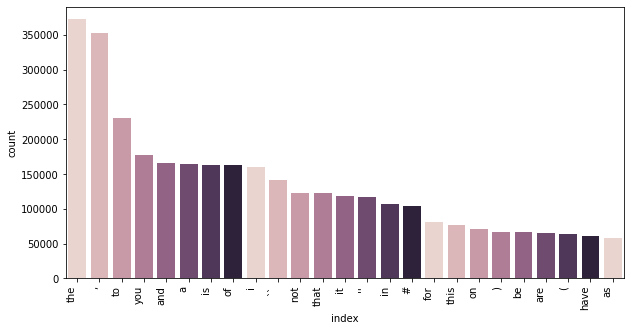

In [25]:
count_df = pd.DataFrame.from_dict({rev_token[k]: v for k, v in sorted(count.items(), key=lambda item: item[1],reverse=True)}, orient='index', columns=["count"] ).reset_index()
print(count_df[:15])
# print(count_df[-10:])
# print(count_df['count'].value_counts())

%matplotlib inline
fig, ax = plt.pyplot.subplots(figsize=(10,5))
chart = sns.barplot(x="index", y="count", data=count_df[:25],palette=sns.cubehelix_palette(8))
chart.set_xticklabels(chart.get_xticklabels(), rotation=90, horizontalalignment='right')

In this step the text will be encoded using the ntlk tokenizer to convert into a list of numbers numbers.

In [20]:
encode_text = token.texts_to_sequences(clean_df.comment_text.tolist())
encode_text_y = clean_df.toxic

In [21]:
encode_text_test = token.texts_to_sequences(["just checking that this sentance splits properly, and returns some type of reasonable result", "hopefully it will"])
print(encode_text_test)
decoded_text_test = []
for lst in encode_text_test:
    decoded_text = []
    for code in lst:
        decoded_text.append(rev_token[code])
    decoded_text_test.append(decoded_text)
print(decoded_text_test)

[[55, 1168, 12, 18, 11896, 18961, 5, 4914, 68, 696, 8, 1097, 736], [1132, 13, 49]]
[['just', 'checking', 'that', 'this', 'sentance', 'splits', 'and', 'returns', 'some', 'type', 'of', 'reasonable', 'result'], ['hopefully', 'it', 'will']]


### Comment Legnth
Here we need to make some practical considerations about comment sizes.  The model used for this project takes the input comments as an array of vectors of equal length.  Knowing this if we take the max size we will be filling most of the array with zeros.  Since comments of extreemly long length are uncommon we should likely take some practical memory considerations and truncate some of the larger sequences at some point.  Below is a graph containing the distribution of text sequence lengths after tokenization.  You can see that there are very few comments larger than 225 words, as such we will stop any comment at 250 tokens.

Max Number of Tokens: 


154362

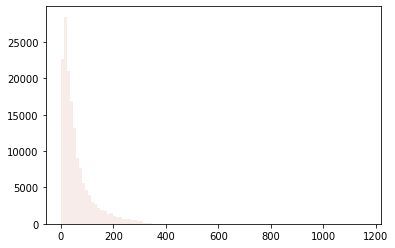

In [30]:
max_tokens = max([len(r) for r in encode_text])
# max_comment_len_list = [len(r) for r in clean_df.comment_text.tolist()]
# print(max_comment_len_list.index(max(max_comment_len_list)))
# print(clean_df.loc[139871,"comment_text"])
print("Max Number of Tokens: ".format(max_tokens))
%matplotlib inline
sns.set_palette(sns.cubehelix_palette(8))
sns.distplot([len(r) for r in encode_text], bins=100, kde=False);
len(clean_df.comment_text)

Here the shorter sequences are padded and the longer truncated to ensure a uniform size.

In [31]:
print( "Number of items with reduced size due to padding: {} ".format(sum([ 1 if len(row_text) > 225 else 0 for row_text in encode_text])))

Number of items with reduced size due to padding: 4596 


In [32]:
encode_text = pad_sequences(encode_text, maxlen=225, padding='post')

## Test Train Split
Here we will randomly split the comment data into Train/Test groups using 80/20.

In [33]:
msk = np.random.rand(len(encode_text)) < 0.8
train_x = encode_text[msk]
train_y = encode_text_y[msk].to_numpy()

test_x = encode_text[~msk]
test_y = encode_text_y[~msk].to_numpy()


## Save Train / Test Sets
This is incase something crashes, we can reload from here without re-running all the previous steps which take hours.


In [35]:
import pickle
with open('train_x.pkl', 'wb') as f:
    pickle.dump(train_x,f)
    
with open( 'train_y.pkl', 'wb') as f:
    pickle.dump(train_y, f)
    
with open( 'test_x.pkl', 'wb') as f:
    pickle.dump(test_x, f)
    
with open( 'test_y.pkl', 'wb') as f:
    pickle.dump(test_y, f)

## Glove

In [ ]:
# glove_vectors = dict()
# filename = 'glove.6B.50d.txt'
# with  open(filename, encoding="utf-8") as file:
#     for l in file:
#         val = l.split()
#         word = val[0]
#         vect = val[1:]
#         glove_vectors[word] = list(map(float, vect))

# vocab_length = len(glove_vectors)
# vocab_length

In [ ]:
# print({k: glove_vectors[k] for k in sorted(glove_vectors.keys())[:5]})
# print(len(ordered_glove_values))
# print(len(glove_vectors))

In [ ]:
# import random
# # ordered_glove_values = [glove_vectors[k] for k in token.word_index.keys()]
# # ordered_glove_values[:5]
# ordered_glove_values = []
# def create_list(n):
#     return [random.random() for i in range(n)]

# for key in list(token.word_index.keys()):
#     if key in glove_vectors:
#         ordered_glove_values.append(glove_vectors[key])
#     else:
#         print(key)
#         ordered_glove_values.append(create_list(50))
        
    

# [len(row) for row in ordered_glove_values]


## Embed Encode Attend Predict
Here is the implementation for the Embed Encode Attend Predict (EEAP) framework.  Much of the code for this section was reporposed from a presentation produced by Martin Gorner of Google and is available on youtube at https://www.youtube.com/watch?v=pzOzmxCR37I&t=1506s

In the examples below the network has been changed in some meaningful ways, specifically but not limited to a a larger RNN with dropout to prevent overfitting.  Different sizes for the RNN and attention layers, coupled with some optimizations for the learning rate and number of steps that is specific to this dataset.


![alt text](eeap.png "Embed Encode Attend Predict Graph")

Above you can see the network for the EEAP framework.
- Embed: input is a the list of tokenized words and outputs a list of vectors
- Encode: input word embeddings are processed through a bidirectional rnn
- Attend: input is the vector output from the RNN.  This is feed into a small neural network.  This ends up learning attributes from the RNN and being able to add higher weights to items of significance.
- Predict: The prediction step from the output of the attention.

In [36]:
def embed(x):
    word_vectors = tf.contrib.layers.embed_sequence(
        x, 
        vocab_size=vocab_size, 
        embed_dim=50)
    
    return word_vectors

In [37]:
def encode(w_vect):
    LAYER_COUNT = 2
    rnn_fw = [tf.contrib.rnn.GRUCell(128) for _ in range(LAYER_COUNT)]
    rnn_bw = [tf.contrib.rnn.GRUCell(128) for _ in range(LAYER_COUNT)]
    rnn_fw[:-1] = [tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=0.5) for cell in rnn_fw[:-1]]
    rnn_bw[:-1] = [tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=0.5) for cell in rnn_bw[:-1]]
    rnn_fw = tf.nn.rnn_cell.MultiRNNCell(rnn_fw, state_is_tuple=False)
    rnn_bw = tf.nn.rnn_cell.MultiRNNCell(rnn_bw, state_is_tuple=False)
    outputs,_= tf.nn.bidirectional_dynamic_rnn(rnn_fw, rnn_bw, w_vect,dtype=tf.float32,time_major=False)
    outputs = tf.concat(outputs, axis = 2)
    return outputs

In [38]:

def attend(alphas, attention_size, attention_depth):
  
    alphas = tf.concat(alphas, axis = 2)

    inputs_shape = alphas.shape
    sequence_length = inputs_shape[1].value
    final_layer_size = inputs_shape[2].value

    x = tf.reshape(alphas, [-1, final_layer_size])
    for _ in range(attention_depth-1):
        x = tf.layers.dense(tf.nn.dropout(x, 0.8), attention_size, activation = tf.nn.relu)
    x = tf.layers.dense(x, 1, activation = None)
    logits = tf.reshape(x, [-1, sequence_length, 1])
    softmax = tf.nn.softmax(logits, dim = 1)

    output = tf.reduce_sum(alphas * softmax, 1)

    return output, alphas

In [39]:
def estimator_spec_for_softmax_classification(
    logits, labels, mode, alphas):
    """Returns EstimatorSpec instance for softmax classification."""

    predicted_classes = tf.argmax(logits, 1)
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(
            mode=mode,
            predictions={
                'class': predicted_classes,
                'prob': tf.nn.softmax(logits),
                'attention': alphas
            })

    onehot_labels = tf.one_hot(labels, 2, 1, 0)
    loss = tf.losses.softmax_cross_entropy(onehot_labels=onehot_labels, logits=logits)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(loss, 
                                      global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode, 
                                          loss=loss, 
                                          train_op=train_op)

    eval_metric_ops = {
      'accuracy': tf.metrics.accuracy(
          labels=labels, predictions=predicted_classes),
      'auc': tf.metrics.auc(
          labels=labels, predictions=predicted_classes),    
    }
    return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [40]:

def predict(encoding, labels, mode, alphas):
    logits = tf.layers.dense(encoding, 2, activation=None)
    return estimator_spec_for_softmax_classification(
          logits=logits, labels=labels, mode=mode, alphas=alphas)

def bi_rnn_model(features, labels, mode):
    """RNN model to predict from sequence of words to a class."""

    word_vectors = embed(features)
    outputs = encode(word_vectors)
    encoding, alphas = attend(outputs, 
                            128, 
                            4)

    return predict(encoding, labels, mode, alphas)


In [41]:

current_time = str(int(time.time()))
model_dir = os.path.join('checkpoints',current_time)
classifier = tf.estimator.Estimator(model_fn=bi_rnn_model, 
                                    model_dir=model_dir)


# Train.
train_input_fn = tf.estimator.inputs.numpy_input_fn(
  x=train_x,
  y=train_y,
  batch_size=512,
  num_epochs=None,
  shuffle=True)

classifier.train(input_fn=train_input_fn, 
                 steps=1400)


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'checkpoints/1598133173', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f86feb1dc88>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized autom

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
dim is deprecated, use axis instead
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Saving checkpoints for 0 into checkpoints/1598133173/model.ckpt.
INFO:tensorflow:loss = 0.68868214, step = 1
INFO:tensorflow:global_step/sec: 0.17759
INFO:tensorflow:loss = 0.18547533, step = 101 (563.105 sec)
INFO:tensorflow:Saving checkpoints for 104 into checkpoints/1598133173/model.ckpt.
INFO:tensorflow:global_step/sec: 0.164625
INFO:tensorflow:loss = 0.106334716, step = 201 (607.461 sec)
INFO:tensorflow:Saving checkpoints for 202 into checkpoints/1598133173/model.ckpt.
INFO:tensorflow:global_step/sec: 0.1706
INFO:tensorflow:loss = 0.11866012, step = 301 (586.140 sec)
INFO:tensorflow:Saving checkpoints for 306 into checkpoints/1598133173/model.ckpt.
INFO:tensorflow:global_step/sec: 0.1

In [42]:
# Predict.
test_input_fn = tf.estimator.inputs.numpy_input_fn(
  x=test_x,
  y=test_y,
  num_epochs=1,
  shuffle=False)

predictions = classifier.predict(input_fn=test_input_fn)

y_predicted = []
alphas_predicted = []
for p in predictions:
    y_predicted.append(p['class'])
    alphas_predicted.append(p['attention'])

scores = classifier.evaluate(input_fn=test_input_fn)
print('Accuracy: {0:f}'.format(scores['accuracy']))
print('AUC: {0:f}'.format(scores['auc']))

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from checkpoints/1598133173/model.ckpt-1400
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-08-22T20:13:55Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from checkpoints/1598133173/model.ckpt-1400
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2020-08-22-20:15:39
INFO:tensorflow:Saving dict for global step 1400: accuracy = 0.9539514, auc = 0.8639751, global_step = 1400, loss = 0.17883219
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1400: checkpoints/1598133173/model.ckpt-1400
Accuracy: 0.953951
AUC: 0.863975


In [44]:
rev_token = {value:key for key, value in token.word_index.items()}

In [45]:

def token_reverse(x):
    txt_token = [rev_token[tok] if tok in rev_token else "" for tok in x]
    return " ".join(txt_token)
test_x_rev_token = [token_reverse(tokens) for tokens in test_x ]
solutions = pd.DataFrame({'predicted':y_predicted,'actual': test_y, 'text': test_x_rev_token  })




## Sample True Positive

In [46]:
solutions[(solutions.predicted == 1) & (solutions.actual==1)].sample(20)

,predicted,actual,text
19549,1,1,my thoughts you are a fucking piece of shit ! die and burn in hell !
26137,1,1,"okay blue tie , you freaking moron , everybody knows how he edits his stuff , just read the hour long article about his controverss and also , why should it be inlcuded ? to keep not as biased as it already is the bird"
7704,1,1,"`` you are a moron plain and simple the movie mentions the word `` '' satan '' for comedy effect suddenly , according to you , everyone involved in the creation and production of the aqua teen hunger force movie is suddenly a real , practicing satanist by the way , the majority of what you just made up is bullshit watched the movie in theaters , and twice on the dvd i can safely say you have not the slightest idea of what you are babbling on about thanks for being a gigantic idiot ``"
1352,1,1,"why not block that cunt samsara for being a pedantic , know nothing twat ? oh , i guess probably because you are one yourself and you guys have got to stick together"
25668,1,1,"and your little faggot boy propol , pray , pray little wonk that i do not find your little ass and kill you"
10251,1,1,ed poor are not no stinkin monkey ! user ed poor are not no stinkin monkey !
6507,1,1,"you can not delete shit from my talk page you faggot , get that shit out of here"
2955,1,1,thats cos im a schitzophrenic toat but ure just an ignorant idiot ill be here long after you have got fed up and left # )
28972,1,1,hey bitch you are the biggest faggot ever ! i know you like that cock in ypur ass and all but do you even feel it anymore or is it like throwing a hotdog down a hallway ? oh yeah by the way your aunt just called she says she wants you out of her basement and she wants you to get a real job you little bitch and one more thing i heard you weigh # pounds ive got a tip get active and eat subway you little bitch !
8757,1,1,why do you keep crying ( bitching ) about every revert ? #


## Sample Type 2 Error

In [47]:
solutions[(solutions.predicted == 0) & (solutions.actual==1)].sample(20)

,predicted,actual,text
9659,0,1,hey barefoot we pwnd you when you came on the guardian try rubbing your kidneys for a bit !
27285,0,1,"table change it back to the list , is so stupid and takes longer to change and edit stuff here my vote is to change it back agrees # disagrees #"
19218,0,1,"`` off to a crap start '' meadowhall is an indoor shopping centre in the sheffield , south yorkshire , england `` '' above is the opening sentence as i found it sheffield is not the sheffield sorted this ``"
16764,0,1,"`` comley stop accusing me of being a vandly , pak # s username is clearly racist and therefore i believe that he should be blocked as im sure you are aware pak is the abriviation of a commonly used racist term for people of asion or pakistani origin please look in the dictionary if you do not understand ( and see if you can find any good words to describe yourself ) i will not tollerate racism on wikipedia and you being a socilist communist `` '' er should not either ``"
29257,0,1,stop as wiki is not a waabi and deobandi platform so do not try ur sick views here first collect correct information and be on siratal mustakeem ( t c )
11186,0,1,"this stub sucks sorry but this is a major museum , and i can not find it in wikipedia there are several images in wikipedia of vehicles which are in the museum , including the tank with david cerny painted pink in # ( one of those pictures is by me , but there are others )"
20740,0,1,better change that to nerd man
26365,0,1,lack of new york post report in the artical lack of lavin new york post report in the artical there should be someting in the artical about lavin exposing olbermann about his alegedly being a pervert with a small penis audio here artical here
26771,0,1,all while real people are spilling real blood and dying real deaths in a real war
11922,0,1,neutralhomer hates black people ! and so does gogo dodo !


Above are examples of comments the EEAP model predicted not toxic but wikipedia concluded was toxic.  Now I am not defending the above statements but several of these are terse or rude but not nessisarliy toxic.  Considering the labels are possibly done by humans you could have some errors on the actual categorization.  Some specific examples include:
    - Item(11654): man let me edit the damn pink spiders page
    - Item(16829) : revert and ask for this page to be protected from vandals like you
    - Item(10059) : im glad you have gone do not come back
    - Item(14825) : collapse hide text bunch of uncivil nonsense
    
    

# Sample Type 1 Error

In [48]:
solutions[(solutions.predicted == 1) & (solutions.actual==0)].sample(20)

,predicted,actual,text
11600,1,0,dude place the following in the large text box please stop raping little boys in the anus do not you know that is illegal ?
12214,1,0,"blunderson , i was talking to you looking at the afghanistan talk page you have been collaborating with everyone of nisarkands now blocked socks either you are both afghan nationalists with afghan nationalist povs or you are online boyfriends which is it blunderson ? ps looser , do not criticize my spelling not a looser like you trying to have perfect spelling when talking to morons like you in all the articles written on wikipedia though my spelling is perfect you on the other hand have contributed nothing to wikipedia except edit warring and many blunders i bet you are a real dumbass in real life and you just use spell check when writing online after all , you have a degree in the easiest major on any campus theology ? your degree is a joke and useless and you are a joke and useless to wikipedia pps by the way stop trying to become an admin asshole , you have a block log and you will never become an admin with that type of record or you can keep wasting your time since you have nothing better to do than to be here # you must smell like a sock by now since sure you have not showered for weeks since you are here # trying to become an admin which will never happen"
5881,1,0,"i would also like to ask , do you regularly spend your time on heidegger and other philosophy articles , or have you only proceeded because of your harassment of me ? i am in the process of improving this article as we speak ( and as you waste one of your betters time with your childish games ) what precisely are you doing ?"
19884,1,0,"you guys do realise that you are not going to stop people enforcing honesty over your sad little corner of the internet , right ? whilst you are pulling your hair out that honest folks like me exist , we are in your wikipedia , correcting your dishonest edits it kills you , i know that , but it is time for the lies to stop , guise"
9504,1,0,"`` now i get your problem you really do not understand what you are being told , so when you call someone an `` '' ignorant ass '' you think that your own self was just mocked first , did i call it confusing ? no i said that you just mentioned it for some reason with no relation to the way it was told or the situation , and i said that it was a reply to you , saying that vandalizing , as you accused me when reverting my contributions , by writing `` '' cum , leave '' makes no sense and your `` '' wp status '' is relevant as i want to know who the hell are you , and what do you want and think when you keep submitting blocks to my user , as well for keeping reverting my talk page when trying to get it clear i do not need this `` '' discussion '' and i was not talking to you and not an `` '' editor '' , all i did was improving that article seen , and that is why you are even more annoying and less helpful ``"
19681,1,0,"`` the problem is that there already is another `` '' planet x '' out there in the media , one which is predicted by delusional freaks who think they have chips in their heads to collide with earth in # that planet x has its own article , zetatalk , so having one article for lowells planet x , one article for other objects called planet x , and another for the loony planet x seems impractical podous ``"
24477,1,0,`` never call him nazi o talk ``
12958,1,0,"you sir have no life , you sped all your time editing on wikipedia ya i bet that gets you lots of chicks"
28817,1,0,"`` i love you jeeny has smiled at you ! smiles promote wikilove and hopefully this one has made your day better spread the wikilove by smiling at someone else , whether it be someone you have had disagreements with in the past or a good friend happy editing ! smile at others by adding to their talk page with a friendly message thank you so much for everything you are great ! because you are related to me , in some weird way ) plus you are a ve

Above you can see some examples of items that clearly the model categorized incorrectly but some of these although techinically incorrect might have been a data collection error.

Examples:
- Item(14509) : what the fuck tce
- Item(29931) : *** text not included ***

## Sample True Negatives

In [49]:
solutions[(solutions.predicted == 0) & (solutions.actual==0)].sample(20)

,predicted,actual,text
29608,0,0,"`` role in the fall of communism i have just added a new section on john paul iis role in the fall of communism i realized afterward that there is mention of this topic in the `` '' relationship with dictatorships '' section however , i think that the topic deserves more than a few sentences tucked away in a section with an unreable title such as `` '' relationship with dictatorships '' ``"
7399,0,0,"ps and world of warcraft and city of heroes city of villains both use it not sure if coh actually keeps track of healing i think only radius heals , if that meaning that if wow does do all heals , describing it in those solid terms will make the article less correct in reference to cohs aggro i also believe that coh also ramps up the hate if a particular creature is weak against a particular attack type"
22329,0,0,"this is a question since it is not easily dissolved in water , what is kcal absorbed by a human body from wheat bran ?"
6398,0,0,feel free to block me longer i guess i lost my interest for the project
22910,0,0,"`` more errors in earlier comments # `` '' batista was known for having his army mutilate opponents and display their dead bodies on television '' this is simply not true , though quaint if compared to gw bush # `` '' pretty much a toss up '' the crimes ( and stupidity ) of castro , guevara and associates has been much greater and longer lasting , destroying the society and economy # since messrs grau and prio were duly elected , they would normally be and were recognized , `` '' despite their opposition to batista '' is a non sequitur ''"
8087,0,0,"rewrite relation to modern climate issues i think this section has to be rewritten taken alone , a niave reader may take this section to mean that this issue creates significant and credible evidence against anthropogenic global warming this is wp undue i suggest rewording there are credible arguments both for and against such a hypothesis to while there have been acadmic arguments both for and against such a hypothesis , the debate has had little impact on the general scientific consensus for man made gobal warming objections ?"
10619,0,0,"as this is all my own opinion or surmise none of it is appropriate for the article , i may be completely wrong and giogn to a reliable source such as ioc publications on the subject would still be needed #"
25752,0,0,"your skin hello , sorry if im bothering you , but could you show me how to use your skin on my homepage ? all help and assistance would be gratefully recieved , thank you"
28707,0,0,"on the scales that you re talking about fewer than a hundred unique sites put together ( # vs # a ratio of # , not # ) , both forms are so rare as to make such comparisons almost irrelevant for this hypothetical reader who wouldn t be able to figure out what ecumenopoleis means from the context , it is given as a plural form at the beginning of the article it is patronising in the extreme to assume that using the etymologically correct plural will cause such difficulties particularly as all readers need do if they are confused is open the ecumenopoleis article in a new tab window to be told what it means in the first sentence the last remaining argument is sthetic it is undeniable that a ending sounds a lot better , and is far easier to say , than a ending"
17212,0,0,"`` regarding `` '' wars argument '' thanks , i will do that soon here is my thinking , krugmans criticism is mentioned # times in a article it is intellectual dishonesty ( and one of character ) to loudly criticize one school of thought and than refuse to even debate for an hour with an actual austrian economist where he has debated with politicians `` '' to boost his book sales '' in his own words so if his critic is in any way or form relevant , why not settle it once for all and end with austrians , or if he does not want to lose his time on irrelevant things , he has humanitarian incentive ( or why call out austrians in a first place ? 

<AxesSubplot:xlabel='predicted', ylabel='actual'>

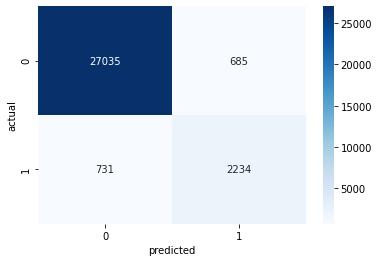

In [52]:
confusion_matrix = pd.crosstab(solutions['actual'], solutions['predicted'], rownames=['actual'], colnames=['predicted'])
%matplotlib inline
sns.heatmap(confusion_matrix, annot=True,cmap='Blues', fmt='d')

## Test Accuracy

In [53]:
print( "Test Accuracy ", (confusion_matrix.loc[0,0] + confusion_matrix.loc[1,1]) / (confusion_matrix.loc[0,0] + confusion_matrix.loc[1,1]+ confusion_matrix.loc[1,0] + confusion_matrix.loc[0,1]))

Test Accuracy  0.9538536744337625


## Embedding Review
Lets take a look at some of those word encoding vectors and see if they learned some sort of pattern.  Famously GloVe embeddings have similar distances between king and queen as they do between him and her.  In this case the focus of the training wasn't nessisarily the words but the end results, in either way we can evaluate distances of synonmys and antonmys to see if we have some pattern.

In [54]:
classifier.get_variable_names()
embedding_lookup = classifier.get_variable_value('EmbedSequence/embeddings')

In [55]:

synonmys_w = ['perhaps', 'maybe', 'possibly', 'conceivably', 'feasibly', 'possible']
antonymns_w = ['certainly','inevitably', 'certain', 'inevitable','definitely','surely' ]
random_v = [ random.randint(1,len(rev_token)) for _ in range(6)]

synonmys_v = [token.word_index[w] for w in  synonmys_w]
antonymns_v = [token.word_index[w] for w in  antonymns_w]
random_w = [rev_token[w] for w in  random_v]

synonmys_e = [embedding_lookup[i] for i in synonmys_v]
antonymns_e = [embedding_lookup[i] for i in antonymns_v]
random_e = [embedding_lookup[i] for i in random_v]

### Euclidean Distance Function
Here we will calculate the distance between respective words.

In [56]:

def distance(v1, v2) :
    return np.linalg.norm(v1-v2)
        
synonmys_dist = distance(synonmys_v[0], synonmys_v[1])

result = []
for i in range(len(synonmys_e)):
    for j in range(len(antonymns_e)):
        if i != j:
            result.append(distance(synonmys_e[i], antonymns_e[j]))

print(result)
print(([distance(v1,v2) for v1 in synonmys_e for v2 in antonymns_e]))

[0.29033905, 0.228878, 0.47191006, 0.16608858, 0.39882907, 0.34883836, 0.23140863, 0.603239, 0.32845628, 0.5290239, 0.3061973, 0.4427857, 0.5910614, 0.29337338, 0.5072404, 0.20371372, 0.30845058, 0.2107647, 0.18652174, 0.4145062, 0.30739146, 0.42299324, 0.16694796, 0.5783617, 0.51848376, 0.2668382, 0.38881835, 0.2787532, 0.66194874, 0.2371056]
[0.1910904, 0.29033905, 0.228878, 0.47191006, 0.16608858, 0.39882907, 0.34883836, 0.45970267, 0.23140863, 0.603239, 0.32845628, 0.5290239, 0.3061973, 0.4427857, 0.21832639, 0.5910614, 0.29337338, 0.5072404, 0.20371372, 0.30845058, 0.2107647, 0.48156407, 0.18652174, 0.4145062, 0.30739146, 0.42299324, 0.16694796, 0.5783617, 0.27596685, 0.51848376, 0.2668382, 0.38881835, 0.2787532, 0.66194874, 0.2371056, 0.3856838]


## Search Distance
Lets try to look at all the words and find the 10 closest and 10 farthest from each other.  Obviously this is going to be computationally complex considering the size of the matrix and this being an n^2 problem.

In [71]:
smallest = [(100,1,1)] * 10
largest = [(-100,1,1)] * 10

words_count = len(embedding_lookup)

for i in range(118577,words_count):
    for j in range(i+1, words_count):

        dist_ = distance(embedding_lookup[i], embedding_lookup[j]) 
        if dist_ < smallest[9][0]:
            smallest[9] = (dist_,i,j)
            smallest = sorted(smallest)
        if dist_ > largest[0][0]:
            largest[0] = (dist_,i,j)
            largest = sorted(largest)
                     

In [72]:
print("LARGEST")
for d,v1,v2 in largest:
    print( f"\'{rev_token[v1]:}\' to \'{rev_token[v2]:}\' distance: {d:.3f}")
print("\nSMALLEST")
for d,v1,v2 in smallest:
    print( f"\'{rev_token[v1]:}\' to \'{rev_token[v2]:}\' distance: {d:.3f}")

LARGEST
'fucking' to 'stranger' distance: 2.303
'conform' to 'cocksucker' distance: 2.312
'reconsider' to 'faggots' distance: 2.314
'fucking' to 'saint' distance: 2.321
'reconsider' to 'cocksucker' distance: 2.323
'fucking' to 'recommend' distance: 2.335
'conform' to 'fucked' distance: 2.344
'reconsider' to 'fucked' distance: 2.360
'fucking' to 'conform' distance: 2.404
'fucking' to 'reconsider' distance: 2.420

SMALLEST
'woolsack' to 'neckbearded' distance: 0.019
'ruffner' to 'signallling' distance: 0.020
'rafique' to 'siddiq' distance: 0.020
'destress' to 'terminalogy' distance: 0.020
'eunapiuss' to 'youngstars' distance: 0.020
'elollipop' to 'colectives' distance: 0.020
'rosenfield' to 'erasmian' distance: 0.020
'flamengo' to 'limehouse' distance: 0.021
'semai' to 'vase' distance: 0.021
'pervy' to 'persnickety' distance: 0.021


### Relative Distance Check

In [85]:
king_v = embedding_lookup[token.word_index['king']]
queen_v = embedding_lookup[token.word_index['queen']]

his_v = embedding_lookup[token.word_index['man']]
her_v = embedding_lookup[token.word_index['woman']]

print(distance(king_v,queen_v))
print(distance(his_v,her_v))


# distance(embedding_lookup[token.word_index['fucking']],embedding_lookup[token.word_index['fucked']])


0.2868683
0.25882998


In [ ]:
# # var = [v for v in tf.trainable_variables() if v.name == "tower_2/filter:0"][0]
# var = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
# print(var)
# [n.name for n in tf.get_default_graph().as_graph_def().node]
# # embedded_words = sess.run(word_vectors)

## Build Network
This contains some steps to build and train the network by hand, this method has some benifits, such as the ability to control a dynamic learning rate, or optimize the stop criteria, but runs much to slow from jupyter notebooks and is a known problem with tensorflow were each re-trainging bactch reloads the graph, causing significant time delays.

In [ ]:
# initial_learning_rate = 0.1
# global_step = tf.Variable(0, trainable=False)
# increment_global_step = tf.assign(global_step, global_step + 1)

# lr_schedule = tf.train.exponential_decay(initial_learning_rate, global_step, 100, 0.95, staircase=False)
# lr = tf.placeholder(tf.float32)

In [ ]:
# EPOC = 1
# TRAINING_SIZE = encode_text.shape[0]
# BATCH_SIZE = 1024

# x = tf.placeholder(tf.int32,[BATCH_SIZE,encode_text.shape[1]])
# y = tf.placeholder(tf.int32,[BATCH_SIZE])
# w_vect = embed(x)
# outputs = encode(w_vect)
# encoding, alphas = attend(outputs, 128,2)
# logits = tf.layers.dense(encoding, 2 , activation=None)
# predicted = tf.argmax(logits, 1)

# y_ = tf.one_hot(y, 2,1,0)

# # accuracy of the trained model, between 0 (worst) and 1 (best)
# correct_prediction = tf.equal(predicted, tf.argmax(y_, 1))
# accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# loss = tf.losses.softmax_cross_entropy(onehot_labels=y_, logits=logits)
# # train_op = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)
# train_op = tf.train.GradientDescentOptimizer(lr).minimize(loss)
# init_op = tf.initialize_all_variables()


In [ ]:
# test_x

In [ ]:
# tf.keras.backend.clear_session()

In [ ]:

# errors = []
# accs = []
# errors_test = []
# accs_test = []
# learning_rate = 0.1
# decay_rate = 0.99
# min_rate = 0.0001
# with tf.Session() as sess:
#     sess.run(init_op)
#     for i in range(EPOC):
#         start = 0
#         print(f"Running EPOC {i}")
# #         print('Learning rate: %f' % (sess.run(trainer ._lr)))
#         for end in range(BATCH_SIZE,TRAINING_SIZE,BATCH_SIZE):
#             x_train_sub = train_x[start:end]
#             y_train_sub = train_y[start:end]
#             _, error_value, accs_value = sess.run([train_op, loss, accuracy], 
#                                                   feed_dict={x: x_train_sub, 
#                                                              y: y_train_sub,
#                                                              lr:learning_rate})
#             test_error_value, test_accs_value = sess.run([loss, accuracy], 
#                                                   feed_dict={x: test_x[:BATCH_SIZE], 
#                                                              y: test_y[:BATCH_SIZE]})
                
#             accs.append(accs_value)
#             errors.append(error_value)
#             errors_test.append(test_error_value)
#             accs_test.append(accs_test)
#             print(f"Loss: {error_value:.3f} \t Acc:{accs_value:.3f}\t Test Loss: {test_error_value:.3f} \t Test Acc:{test_accs_value:.3f}\t lr:{learning_rate:.5f}")
#             start = end
            
#             learning_rate = learning_rate * decay_rate
#             if learning_rate < min_rate:
#                 learning_rate = min_rate

In [ ]:
# %matplotlib inline
# sns.lineplot(x=list(range(0,len(errors))), y=errors)
# sns.lineplot(x=list(range(0,len(accs))), y=accs)
# sns.lineplot(x=list(range(0,len(errors_test))), y=errors_test)
# sns.lineplot(x=list(range(0,len(accs_test))), y=accs_test)